# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install and load dependencies

This setup installs and loads all required packages for ERA5 data handling.

In [ ]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00


In [ ]:
# Install netCDF4
!pip install netCDF4

# Then try again
import xarray as xr

ds = xr.open_dataset(
    '/content/drive/MyDrive/data_stream-oper_stepType-accum.nc'
)

In [ ]:
# Load ERA5 NetCDF data
import xarray as xr

# Explicitly use netCDF4 engine instead of h5netcdf
ds = xr.open_dataset(
    '/content/drive/MyDrive/data_stream-oper_stepType-accum.nc',
    engine='netcdf4'
)
#ds1 = xr.open_dataset("/content/drive/MyDrive/data_stream-oper_stepType-instant.nc")

print("Dataset structure:")
print(ds)

# Variable names might differ - adjust as needed
# Common ERA5 variable names: 't2m', 'tp', 'msl'
#temp_var = 't2m' if 't2m' in ds.variables else '2m_temperature'
precip_var = 'tp' if 'tp' in ds.variables else 'total_precipitation'
#pressure_var = 'msl' if 'msl' in ds.variables else 'mean_sea_level_pressure'


Dataset structure:
<xarray.Dataset> Size: 5MB
Dimensions:     (valid_time: 91, latitude: 121, longitude: 121)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 728B 2024-01-01 ... 2024-03-31
  * latitude    (latitude) float64 968B 60.0 59.75 59.5 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 968B -10.0 -9.75 -9.5 ... 19.5 19.75 20.0
    number      int64 8B ...
    expver      (valid_time) <U4 1kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-16T04:36 GRIB to CDM+CF via cfgrib-0.9.1...


## Download ERA5 Data

We'll download ERA5 climate data. You'll need to set up CDS API credentials first:
1. Register at https://cds.climate.copernicus.eu
2. Create ~/.cdsapirc with your credentials

## Load and Preprocess ERA5 Data

In [ ]:
# Load ERA5 NetCDF data
ds1 = xr.open_dataset("/content/drive/MyDrive/data_stream-oper_stepType-accum.nc",engine='netcdf4')
ds = xr.open_dataset("/content/drive/MyDrive/data_stream-oper_stepType-instant.nc",engine='netcdf4')

print("Dataset structure:")
print(ds)

# Variable names might differ - adjust as needed
# Common ERA5 variable names: 't2m', 'tp', 'msl'
temp_var = 't2m' if 't2m' in ds.variables else '2m_temperature'
precip_var = 'tp' if 'tp' in ds1.variables else 'total_precipitation'
pressure_var = 'msl' if 'msl' in ds.variables else 'mean_sea_level_pressure'

# Extract data
temperature = ds[temp_var].values
precipitation = ds1[precip_var].values # Corrected: extract precipitation from ds1
pressure = ds[pressure_var].values
latitude = ds['latitude'].values
longitude = ds['longitude'].values
time = ds['valid_time'].values # Corrected: use 'valid_time' from ds

print(f"\nData shapes:")
print(f"Temperature: {temperature.shape}")
print(f"Precipitation: {precipitation.shape}")
print(f"Pressure: {pressure.shape}")
print(f"Latitude: {latitude.shape}")
print(f"Longitude: {longitude.shape}")
print(f"Time: {time.shape}")

Dataset structure:
<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 91, latitude: 121, longitude: 121)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 728B 2024-01-01 ... 2024-03-31
  * latitude    (latitude) float64 968B 60.0 59.75 59.5 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 968B -10.0 -9.75 -9.5 ... 19.5 19.75 20.0
    number      int64 8B ...
    expver      (valid_time) <U4 1kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 5MB ...
    msl         (valid_time, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-16T04:36 GRIB to CDM+CF via cfgrib-0.9.1...

Data shapes:
Temperature: (91, 121, 121)
Precipitation: (91, 121, 121)
Pre

## Create Spatial DataFrame

Convert ERA5 grid data into a spatial dataframe format compatible with SpaceGAN.
Each row represents a spatial location at a specific time.

In [ ]:
def create_spatial_dataframe(temperature, precipitation, pressure, latitude, longitude, time_steps):
    """
    Convert ERA5 gridded data to spatial dataframe (optimized version)

    Args:
        temperature: [time, lat, lon]
        precipitation: [time, lat, lon]
        pressure: [time, lat, lon]
        latitude: [lat]
        longitude: [lon]
        time_steps: number of time steps to use

    Returns:
        DataFrame with spatial points and climate variables
    """
    import numpy as np

    # Limit time steps
    n_time = min(time_steps, temperature.shape[0])

    # Slice the data first
    temp_subset = temperature[:n_time, :, :]
    precip_subset = precipitation[:n_time, :, :]
    press_subset = pressure[:n_time, :, :]

    # Create meshgrid for coordinates
    lon_grid, lat_grid = np.meshgrid(longitude, latitude)

    # Flatten everything at once (MUCH faster than loops)
    time_indices = np.repeat(np.arange(n_time), len(latitude) * len(longitude))
    lat_flat = np.tile(lat_grid.flatten(), n_time)
    lon_flat = np.tile(lon_grid.flatten(), n_time)
    temp_flat = temp_subset.flatten()
    precip_flat = precip_subset.flatten()
    press_flat = press_subset.flatten()

    # Create dataframe directly from arrays
    df = pd.DataFrame({
        'time_idx': time_indices,
        'latitude': lat_flat,
        'longitude': lon_flat,
        'temperature': temp_flat,
        'precipitation': precip_flat,
        'pressure': press_flat
    })

    # Remove NaN values
    df = df.dropna()

    return df

# Create dataframe (use first 10 time steps)
df = create_spatial_dataframe(
    temperature, precipitation, pressure,
    latitude, longitude,
    time_steps=10
)

print(f"Created spatial dataframe with {len(df)} points")
print(f"\nSample data:")
print(df.head())
print(f"\nData statistics:")
print(df.describe())

Created spatial dataframe with 146410 points

Sample data:
   time_idx  latitude  longitude  temperature  precipitation  pressure
0         0      60.0     -10.00   281.370361       0.000002  98372.50
1         0      60.0      -9.75   281.434814       0.000002  98390.75
2         0      60.0      -9.50   281.526611       0.000007  98406.25
3         0      60.0      -9.25   281.653564       0.000019  98417.25
4         0      60.0      -9.00   281.762939       0.000043  98426.75

Data statistics:
            time_idx       latitude      longitude    temperature  \
count  146410.000000  146410.000000  146410.000000  146410.000000   
mean        4.500000      45.000000       5.000000     279.729706   
std         2.872291       8.732154       8.732154       6.981915   
min         0.000000      30.000000     -10.000000     243.841431   
25%         2.000000      37.500000      -2.500000     275.952759   
50%         4.500000      45.000000       5.000000     280.379883   
75%         7.

## Visualize ERA5 Data

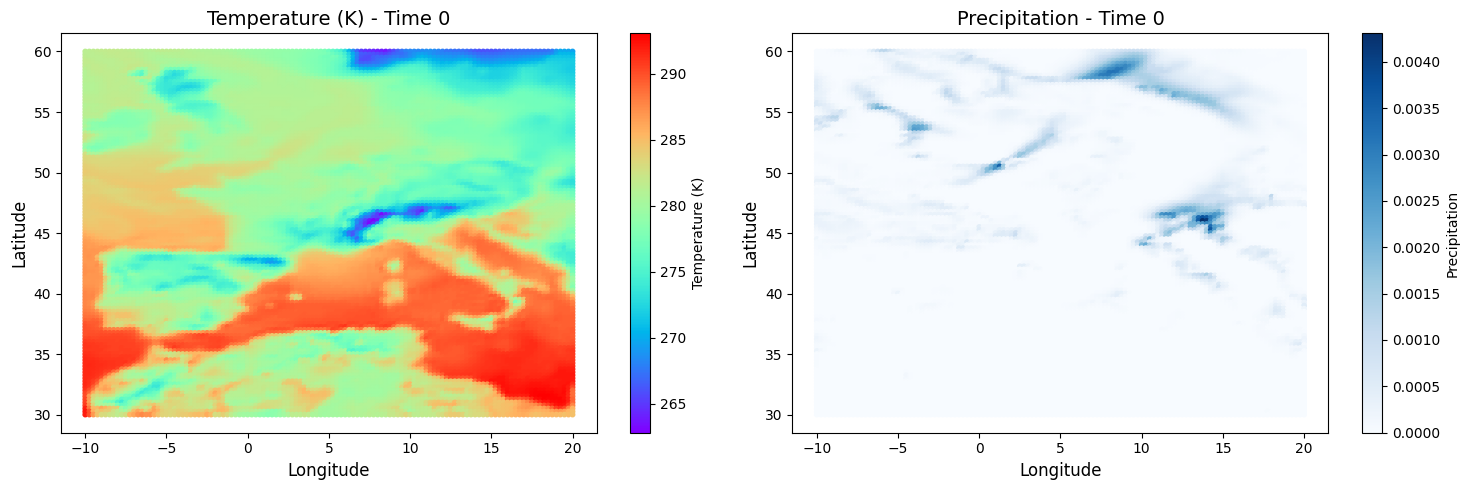

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Filter data for time 0
df_t0 = df[df['time_idx'] == 0]

# Temperature - vectorized (MUCH faster)
scatter1 = ax1.scatter(df_t0['longitude'], df_t0['latitude'],
                       c=df_t0['temperature'], cmap='rainbow', s=10)
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Temperature (K) - Time 0', fontsize=14)
plt.colorbar(scatter1, ax=ax1, label='Temperature (K)')

# Precipitation - vectorized (MUCH faster)
scatter2 = ax2.scatter(df_t0['longitude'], df_t0['latitude'],
                       c=df_t0['precipitation'], cmap='Blues', s=10)
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax2.set_title('Precipitation - Time 0', fontsize=14)
plt.colorbar(scatter2, ax=ax2, label='Precipitation')

plt.tight_layout()
plt.show()

## Define Variables for SpaceGAN

Configure which variables to use as:
- **Coordinates**: latitude, longitude, time
- **Conditional variables**: predictors (lat, lon, time, pressure)
- **Context variables**: neighbor features
- **Output variables**: target prediction (temperature, precipitation)

In [ ]:
# Define spatial coordinates
coord_vars = ['longitude', 'latitude', 'time_idx']

# Define conditional/predictor variables (inputs to generator)
cond_vars = ['pressure'] + coord_vars

# Define context variables (from neighbors)
cont_vars = ['temperature', 'precipitation', 'pressure'] + coord_vars

# Define output variables (what we want to predict)
output_vars = ['temperature', 'precipitation']

# Number of spatial neighbors to consider
neighbours = 10  # Reduced from 50 for spatial data

print(f"Coordinate variables: {coord_vars}")
print(f"Conditional variables: {cond_vars}")
print(f"Context variables: {cont_vars}")
print(f"Output variables: {output_vars}")
print(f"Number of neighbors: {neighbours}")

Coordinate variables: ['longitude', 'latitude', 'time_idx']
Conditional variables: ['pressure', 'longitude', 'latitude', 'time_idx']
Context variables: ['temperature', 'precipitation', 'pressure', 'longitude', 'latitude', 'time_idx']
Output variables: ['temperature', 'precipitation']
Number of neighbors: 10


## SpaceGAN Utility Functions

In [ ]:
def gaussian(size=(1, 1), **kwargs):
    """Generate Gaussian noise"""
    if kwargs.get("params") is None:
        return np.random.normal(0, 1, size=size)
    else:
        return np.random.normal(
            kwargs["params"]["loc"],
            kwargs["params"]["scale"],
            size=size
        )

def get_neighbours_featurize(df, coord_vars, cont_vars, k):
    """
    Get k nearest neighbors for each point and add their features

    Args:
        df: DataFrame with spatial data
        coord_vars: coordinate column names
        cont_vars: context variables to extract from neighbors
        k: number of neighbors

    Returns:
        df_features: DataFrame with neighbor features added
        neighbor_list: list of neighbor indices
    """

    # Extract coordinates
    coords = df[coord_vars].values

    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    # Exclude self (first neighbor)
    neighbor_indices = indices[:, 1:]

    # Extract neighbor features
    df_copy = df.copy()

    for i in range(k):
        for var in cont_vars:
            neighbor_vals = df[var].iloc[neighbor_indices[:, i]].values
            df_copy[f'neighbor_{i}_{var}'] = neighbor_vals

    return df_copy, neighbor_indices.tolist()

print("Utility functions defined")

Utility functions defined


## Featurize with Neighbors

In [ ]:
# Add neighbor features
print("Computing neighbors and features...")
df_features, neighbour_list = get_neighbours_featurize(df, coord_vars, cont_vars, neighbours)

print(f"\nFeaturized dataframe shape: {df_features.shape}")
print(f"Number of features: {len(df_features.columns)}")
print(f"\nSample features:")
print(df_features.iloc[0])

Computing neighbors and features...

Featurized dataframe shape: (146410, 66)
Number of features: 66

Sample features:
time_idx                        0.000000
latitude                       60.000000
longitude                     -10.000000
temperature                   281.370361
precipitation                   0.000002
                                ...     
neighbor_9_precipitation        0.000000
neighbor_9_pressure         98330.750000
neighbor_9_longitude          -10.000000
neighbor_9_latitude            59.250000
neighbor_9_time_idx             0.000000
Name: 0, Length: 66, dtype: float64


## SpaceGAN Code Base

We start with defining the *SpaceGAN* class (same as original).

In [ ]:
class SpaceGAN:
    def __init__(self, prob_config, check_config, disc_method, gen_method):
        # problem dimension
        self.latent = prob_config["noise_type"]  # noise function
        self.latent_dim = prob_config["noise_dim"]  # noise size
        self.latent_params = prob_config["noise_params"]  # noise params
        self.conditional_dim = prob_config["cond_dim"]  # conditional info
        self.output_dim = prob_config["output_dim"] # output dim
        self.output_labels = prob_config["output_labels"]
        self.input_labels = prob_config["input_labels"]

        # training
        self.epochs = prob_config["epochs"]
        self.batch_size = prob_config["batch_size"]
        self.discriminator = disc_method
        self.disc_opt = prob_config["disc_opt"](self.discriminator.parameters(), **prob_config["disc_opt_params"])
        self.generator = gen_method
        self.gen_opt = prob_config["gen_opt"](self.generator.parameters(), **prob_config["gen_opt_params"])
        self.loss = prob_config["adversarial_loss"]
        self.device = prob_config["device"]
        self.print_results = prob_config["print_results"]

        # selection
        self.check_interval = check_config["check_interval"]
        self.generate_image = check_config.get("generate_image", False)
        self.n_samples = check_config["n_samples"]
        self.perf_metrics = check_config["perf_metrics"]
        self.perf_metrics_setting = check_config.get("pf_metrics_setting", {})
        self.agg_funcs = check_config.get("agg_funcs", [])
        self.agg_metrics = check_config.get("agg_metrics", [])

        # scaling for input and output
        self.scaling_method_x = prob_config["scale_x"]
        self.scaling_method_y = prob_config["scale_y"]

        # checkpoints
        self.checkpoints = {}

    def train(self, X_train, y_train):
        """
        Train the SpaceGAN model

        Args:
            X_train: conditional features [n_samples, cond_dim]
            y_train: target outputs [n_samples, output_dim]
        """
        # Scale data
        X_scaled = self.scaling_method_x.fit_transform(X_train)
        y_scaled = self.scaling_method_y.fit_transform(y_train)

        # Convert to tensors
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        y_tensor = torch.FloatTensor(y_scaled).to(self.device)

        n_samples = X_tensor.shape[0]

        # Training loop
        for epoch in tqdm(range(self.epochs), desc="Training SpaceGAN"):
            # Sample random batch
            idx = np.random.choice(n_samples, self.batch_size, replace=False)
            real_data = y_tensor[idx]
            cond_data = X_tensor[idx]

            # Generate noise
            noise = torch.FloatTensor(
                self.latent(size=(self.batch_size, self.latent_dim), params=self.latent_params)
            ).to(self.device)

            # =================== Train Discriminator ===================
            self.disc_opt.zero_grad()

            # Real data
            real_validity = self.discriminator(real_data, cond_data)
            real_labels = torch.ones(self.batch_size, 1).to(self.device)
            real_loss = self.loss(real_validity, real_labels)

            # Fake data
            fake_data = self.generator(noise, cond_data)
            fake_validity = self.discriminator(fake_data.detach(), cond_data)
            fake_labels = torch.zeros(self.batch_size, 1).to(self.device)
            fake_loss = self.loss(fake_validity, fake_labels)

            # Total discriminator loss
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            self.disc_opt.step()

            # =================== Train Generator ===================
            self.gen_opt.zero_grad()

            # Generate fake data
            fake_data = self.generator(noise, cond_data)
            fake_validity = self.discriminator(fake_data, cond_data)

            # Generator loss (fool discriminator)
            g_loss = self.loss(fake_validity, real_labels)
            g_loss.backward()
            self.gen_opt.step()

            # Checkpoint
            if (epoch + 1) % self.check_interval == 0:
                self.checkpoints[epoch + 1] = {
                    'generator': self.generator.state_dict(),
                    'discriminator': self.discriminator.state_dict(),
                    'd_loss': d_loss.item(),
                    'g_loss': g_loss.item()
                }

                if self.print_results:
                    print(f"Epoch {epoch+1}/{self.epochs} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    def generate(self, X_cond, n_samples=None):
        """
        Generate synthetic samples

        Args:
            X_cond: conditional features
            n_samples: number of samples (uses X_cond size if None)

        Returns:
            Generated samples
        """
        if n_samples is None:
            n_samples = X_cond.shape[0]

        # Scale conditional data
        X_scaled = self.scaling_method_x.transform(X_cond)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        # Generate noise
        noise = torch.FloatTensor(
            self.latent(size=(n_samples, self.latent_dim), params=self.latent_params)
        ).to(self.device)

        # Generate samples
        with torch.no_grad():
            fake_data = self.generator(noise, X_tensor)

        # Denormalize
        fake_data_np = fake_data.cpu().numpy()
        fake_data_denorm = self.scaling_method_y.inverse_transform(fake_data_np)

        return fake_data_denorm

print("SpaceGAN class defined")

SpaceGAN class defined


## Networks

We now define the Generator (G) and Discriminator (D) architecture (same as original).

In [ ]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self, cond_dim, noise_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(cond_dim + noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, z, cond_info):
        input_data = torch.cat([z, cond_info], dim=1).float()
        data = self.model(input_data).float()
        return data

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, output_dim, cond_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(output_dim + cond_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, data, cond_info):
        input_data = torch.cat([data, cond_info], dim=1).float()
        validity = self.model(input_data).float()
        return validity

print("Generator and Discriminator architectures defined")

Generator and Discriminator architectures defined


## Training Configuration

Configure the SpaceGAN model for ERA5 climate data.

In [ ]:
# Problem configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Calculate dimensions
cond_dim = len(cond_vars) + (neighbours * len(cont_vars))
output_dim = len(output_vars)
noise_dim = cond_dim  # Same as conditional dimension

prob_config = {
    "epochs": 1000,  # Reduced for testing
    "batch_size": 64,
    "device": device,
    "cond_dim": cond_dim,
    "output_dim": output_dim,
    "noise_dim": noise_dim,
    "noise_type": gaussian,
    "noise_params": None,
    "scale_x": StandardScaler(),
    "scale_y": StandardScaler(),
    "print_results": True,
    "output_labels": output_vars,
    "input_labels": cond_vars,
    "gen_opt": torch.optim.Adam,
    "gen_opt_params": {"lr": 0.001},
    "disc_opt": torch.optim.Adam,
    "disc_opt_params": {"lr": 0.001},
    "adversarial_loss": nn.BCELoss()
}

# Checkpointing configuration
check_config = {
    "check_interval": 100,
    "generate_image": False,
    "n_samples": 1000,
    "perf_metrics": [],
    "pf_metrics_setting": {},
    "agg_funcs": [],
    "agg_metrics": []
}

print(f"\nConfiguration:")
print(f"Conditional dimension: {cond_dim}")
print(f"Output dimension: {output_dim}")
print(f"Noise dimension: {noise_dim}")
print(f"Batch size: {prob_config['batch_size']}")
print(f"Epochs: {prob_config['epochs']}")

Using device: cpu

Configuration:
Conditional dimension: 64
Output dimension: 2
Noise dimension: 64
Batch size: 64
Epochs: 1000


## Prepare Training Data

In [ ]:
# Get conditional features (input)
cond_feature_cols = cond_vars.copy()
for i in range(neighbours):
    for var in cont_vars:
        cond_feature_cols.append(f'neighbor_{i}_{var}')

X_train = df_features[cond_feature_cols].values
y_train = df_features[output_vars].values

print(f"Training data shapes:")
print(f"X_train (conditional): {X_train.shape}")
print(f"y_train (output): {y_train.shape}")

# OPTIMIZED: Check for NaN values more efficiently
print("\nChecking for NaN values...")

# Use pandas dropna (much faster than numpy operations)
valid_mask = df_features[cond_feature_cols + output_vars].notna().all(axis=1)
n_invalid = (~valid_mask).sum()

if n_invalid > 0:
    print(f"Warning: {n_invalid} rows with NaN values detected! Removing...")
    X_train = X_train[valid_mask]
    y_train = y_train[valid_mask]
    print(f"Cleaned shapes: X={X_train.shape}, y={y_train.shape}")
else:
    print("No NaN values found!")

print(f"\nFinal training data ready:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

Training data shapes:
X_train (conditional): (146410, 64)
y_train (output): (146410, 2)

Checking for NaN values...
No NaN values found!

Final training data ready:
  X_train: (146410, 64)
  y_train: (146410, 2)


## Initialize and Train SpaceGAN

In [ ]:
# Initialize networks
generator = Generator(cond_dim, noise_dim, output_dim).to(device)
discriminator = Discriminator(output_dim, cond_dim).to(device)

print("Networks initialized:")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

# Create SpaceGAN model
spacegan = SpaceGAN(prob_config, check_config, discriminator, generator)

print("\nStarting training...")
spacegan.train(X_train, y_train)
print("Training complete!")

Networks initialized:
Generator parameters: 24,898
Discriminator parameters: 6,401

Starting training...


Training SpaceGAN:  12%|█▏        | 123/1000 [00:01<00:06, 131.77it/s]

Epoch 100/1000 - D_loss: 0.6272, G_loss: 0.7915


Training SpaceGAN:  22%|██▏       | 221/1000 [00:01<00:05, 130.64it/s]

Epoch 200/1000 - D_loss: 0.5474, G_loss: 1.0788


Training SpaceGAN:  32%|███▏      | 319/1000 [00:02<00:05, 127.80it/s]

Epoch 300/1000 - D_loss: 0.6450, G_loss: 0.9031


Training SpaceGAN:  42%|████▏     | 417/1000 [00:03<00:04, 135.25it/s]

Epoch 400/1000 - D_loss: 0.8119, G_loss: 0.5660


Training SpaceGAN:  52%|█████▏    | 518/1000 [00:04<00:03, 135.12it/s]

Epoch 500/1000 - D_loss: 0.6415, G_loss: 0.6946


Training SpaceGAN:  62%|██████▏   | 617/1000 [00:04<00:02, 133.77it/s]

Epoch 600/1000 - D_loss: 0.6749, G_loss: 0.7658


Training SpaceGAN:  72%|███████▏  | 716/1000 [00:05<00:02, 134.20it/s]

Epoch 700/1000 - D_loss: 0.7883, G_loss: 0.5673


Training SpaceGAN:  81%|████████▏ | 814/1000 [00:06<00:01, 133.59it/s]

Epoch 800/1000 - D_loss: 0.6238, G_loss: 0.9452


Training SpaceGAN:  91%|█████████▏| 914/1000 [00:07<00:00, 132.24it/s]

Epoch 900/1000 - D_loss: 0.6766, G_loss: 0.7692


Training SpaceGAN: 100%|██████████| 1000/1000 [00:07<00:00, 127.74it/s]

Epoch 1000/1000 - D_loss: 0.6918, G_loss: 0.6768
Training complete!


## Generate Predictions

In [ ]:
# Generate predictions for test set (using same data for demo)
n_test = min(1000, X_train.shape[0])
X_test = X_train[:n_test]
y_test = y_train[:n_test]

print(f"Generating predictions for {n_test} samples...")
y_pred = spacegan.generate(X_test)

print(f"\nPrediction shape: {y_pred.shape}")
print(f"\nPrediction statistics:")
print(f"Temperature - Mean: {y_pred[:, 0].mean():.2f}, Std: {y_pred[:, 0].std():.2f}")
print(f"Precipitation - Mean: {y_pred[:, 1].mean():.6f}, Std: {y_pred[:, 1].std():.6f}")

Generating predictions for 1000 samples...

Prediction shape: (1000, 2)

Prediction statistics:
Temperature - Mean: 280.87, Std: 1.26
Precipitation - Mean: 0.000258, Std: 0.000162


## Visualize Results

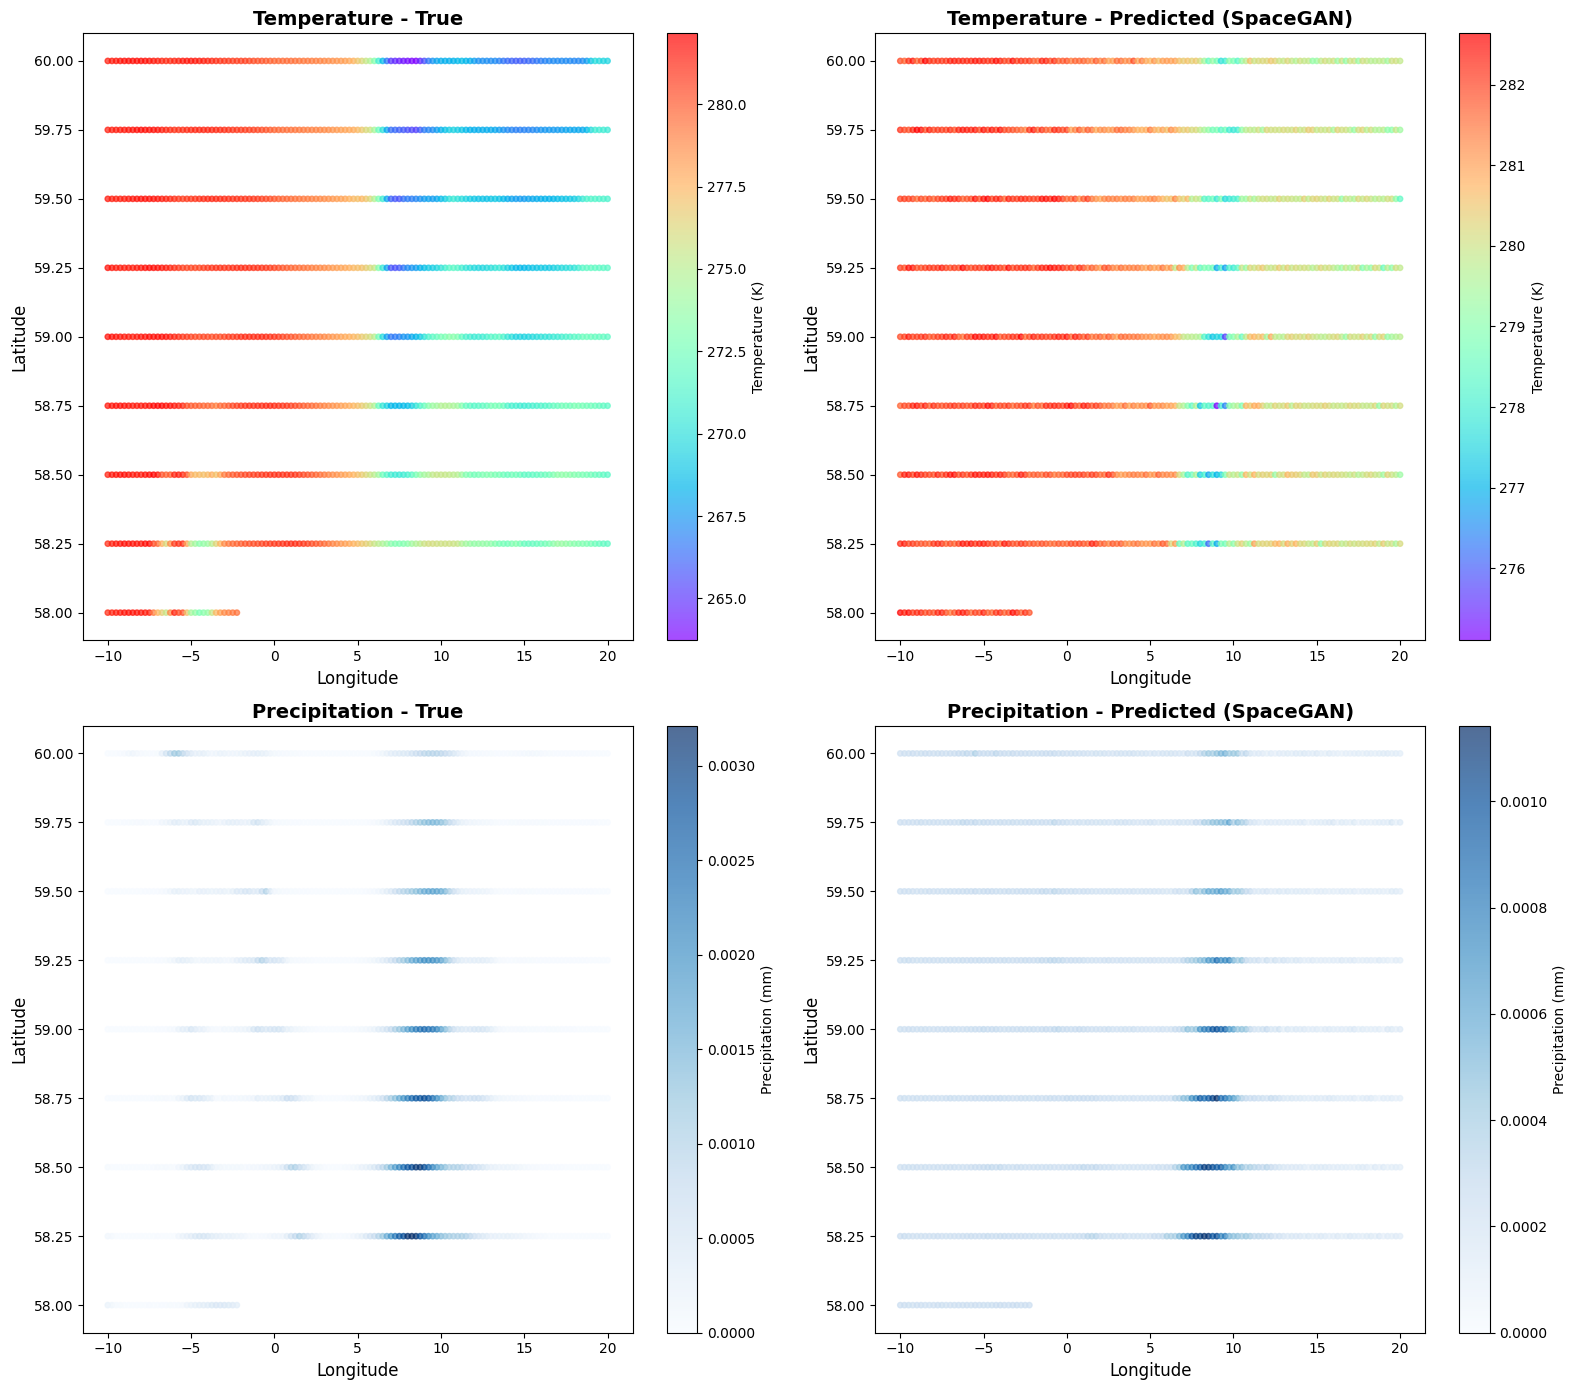


Results saved to: spacegan_era5_results.png


In [ ]:
%matplotlib inline

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Get spatial coordinates for test set
test_lats = df_features.iloc[:n_test]['latitude'].values
test_lons = df_features.iloc[:n_test]['longitude'].values

# Temperature - True
temp_true = y_test[:, 0]
sc1 = axes[0, 0].scatter(test_lons, test_lats, c=temp_true,
                         cmap='rainbow', s=15, alpha=0.7)
axes[0, 0].set_title('Temperature - True', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude', fontsize=12)
axes[0, 0].set_ylabel('Latitude', fontsize=12)
plt.colorbar(sc1, ax=axes[0, 0], label='Temperature (K)')

# Temperature - Predicted
temp_pred = y_pred[:, 0]
sc2 = axes[0, 1].scatter(test_lons, test_lats, c=temp_pred,
                         cmap='rainbow', s=15, alpha=0.7)
axes[0, 1].set_title('Temperature - Predicted (SpaceGAN)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude', fontsize=12)
axes[0, 1].set_ylabel('Latitude', fontsize=12)
plt.colorbar(sc2, ax=axes[0, 1], label='Temperature (K)')

# Precipitation - True
precip_true = y_test[:, 1]
sc3 = axes[1, 0].scatter(test_lons, test_lats, c=precip_true,
                         cmap='Blues', s=15, alpha=0.7, vmin=0)
axes[1, 0].set_title('Precipitation - True', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitude', fontsize=12)
axes[1, 0].set_ylabel('Latitude', fontsize=12)
plt.colorbar(sc3, ax=axes[1, 0], label='Precipitation (mm)')

# Precipitation - Predicted
precip_pred = y_pred[:, 1]
sc4 = axes[1, 1].scatter(test_lons, test_lats, c=precip_pred,
                         cmap='Blues', s=15, alpha=0.7, vmin=0)
axes[1, 1].set_title('Precipitation - Predicted (SpaceGAN)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitude', fontsize=12)
axes[1, 1].set_ylabel('Latitude', fontsize=12)
plt.colorbar(sc4, ax=axes[1, 1], label='Precipitation (mm)')

plt.tight_layout()
plt.savefig('spacegan_era5_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to: spacegan_era5_results.png")

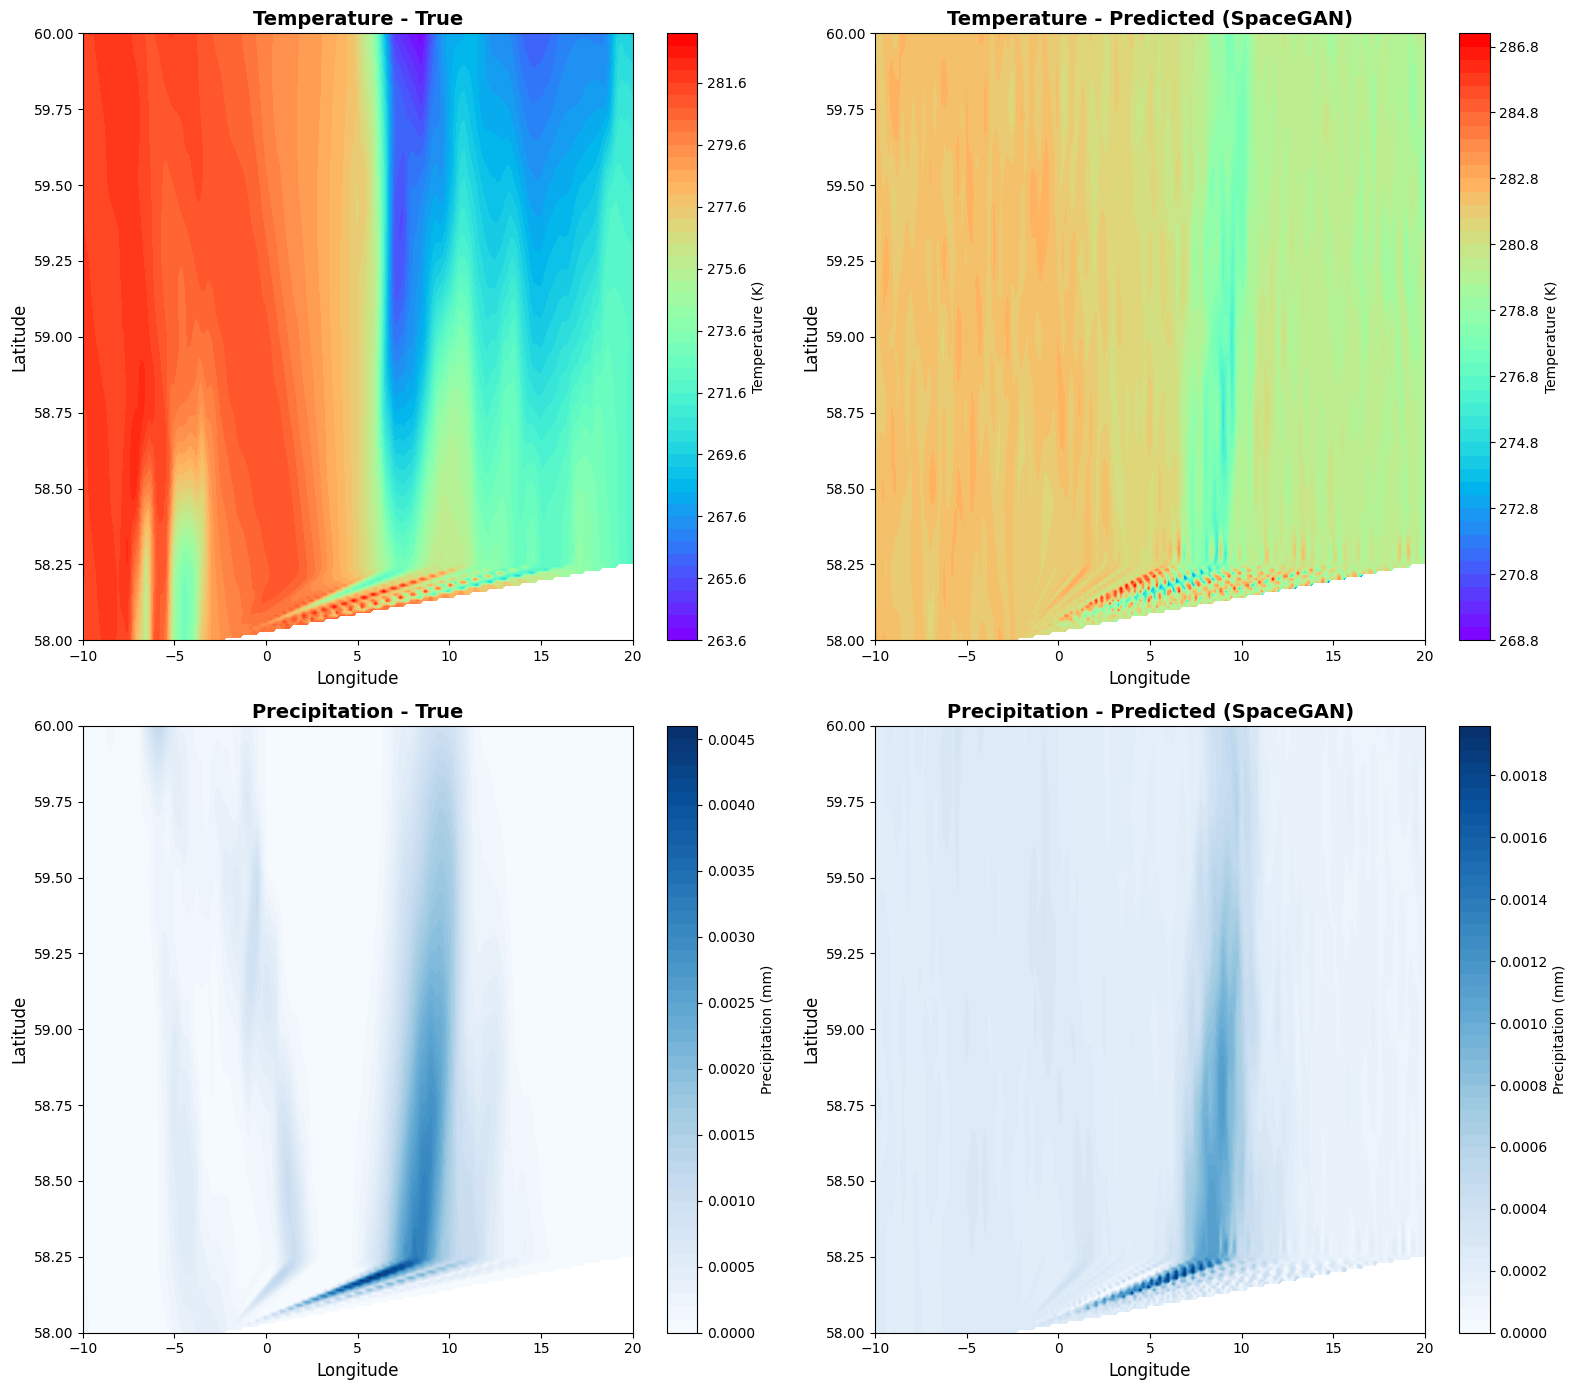


Interpolated results saved to: spacegan_era5_results_interpolated.png


In [ ]:
%matplotlib inline
import numpy as np
from scipy.interpolate import griddata

# Create comparison plots with interpolation
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Get spatial coordinates for test set
test_lats = df_features.iloc[:n_test]['latitude'].values
test_lons = df_features.iloc[:n_test]['longitude'].values

# Create regular grid for interpolation
lon_min, lon_max = test_lons.min(), test_lons.max()
lat_min, lat_max = test_lats.min(), test_lats.max()
grid_lon, grid_lat = np.meshgrid(
    np.linspace(lon_min, lon_max, 200),
    np.linspace(lat_min, lat_max, 200)
)

# Temperature - True
temp_true = y_test[:, 0]
temp_true_grid = griddata(
    (test_lons, test_lats), temp_true,
    (grid_lon, grid_lat), method='cubic'
)
im1 = axes[0, 0].contourf(grid_lon, grid_lat, temp_true_grid,
                          levels=50, cmap='rainbow')
axes[0, 0].set_title('Temperature - True', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude', fontsize=12)
axes[0, 0].set_ylabel('Latitude', fontsize=12)
plt.colorbar(im1, ax=axes[0, 0], label='Temperature (K)')

# Temperature - Predicted
temp_pred = y_pred[:, 0]
temp_pred_grid = griddata(
    (test_lons, test_lats), temp_pred,
    (grid_lon, grid_lat), method='cubic'
)
im2 = axes[0, 1].contourf(grid_lon, grid_lat, temp_pred_grid,
                          levels=50, cmap='rainbow')
axes[0, 1].set_title('Temperature - Predicted (SpaceGAN)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude', fontsize=12)
axes[0, 1].set_ylabel('Latitude', fontsize=12)
plt.colorbar(im2, ax=axes[0, 1], label='Temperature (K)')

# Precipitation - True
precip_true = y_test[:, 1]
precip_true_grid = griddata(
    (test_lons, test_lats), precip_true,
    (grid_lon, grid_lat), method='cubic'
)
precip_true_grid = np.maximum(precip_true_grid, 0)  # No negative precip
im3 = axes[1, 0].contourf(grid_lon, grid_lat, precip_true_grid,
                          levels=50, cmap='Blues')
axes[1, 0].set_title('Precipitation - True', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitude', fontsize=12)
axes[1, 0].set_ylabel('Latitude', fontsize=12)
plt.colorbar(im3, ax=axes[1, 0], label='Precipitation (mm)')

# Precipitation - Predicted
precip_pred = y_pred[:, 1]
precip_pred_grid = griddata(
    (test_lons, test_lats), precip_pred,
    (grid_lon, grid_lat), method='cubic'
)
precip_pred_grid = np.maximum(precip_pred_grid, 0)  # No negative precip
im4 = axes[1, 1].contourf(grid_lon, grid_lat, precip_pred_grid,
                          levels=50, cmap='Blues')
axes[1, 1].set_title('Precipitation - Predicted (SpaceGAN)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitude', fontsize=12)
axes[1, 1].set_ylabel('Latitude', fontsize=12)
plt.colorbar(im4, ax=axes[1, 1], label='Precipitation (mm)')

plt.tight_layout()
plt.savefig('spacegan_era5_results_interpolated.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpolated results saved to: spacegan_era5_results_interpolated.png")

## Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse_temp = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mae_temp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
r2_temp = r2_score(y_test[:, 0], y_pred[:, 0])

mse_precip = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_precip = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_precip = r2_score(y_test[:, 1], y_pred[:, 1])

print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print("\nTemperature:")
print(f"  MSE:  {mse_temp:.4f}")
print(f"  RMSE: {np.sqrt(mse_temp):.4f}")
print(f"  MAE:  {mae_temp:.4f}")
print(f"  R²:   {r2_temp:.4f}")

print("\nPrecipitation:")
print(f"  MSE:  {mse_precip:.6f}")
print(f"  RMSE: {np.sqrt(mse_precip):.6f}")
print(f"  MAE:  {mae_precip:.6f}")
print(f"  R²:   {r2_precip:.4f}")
print("=" * 60)

## Save Model

In [ ]:
# Save trained model
torch.save({
    'generator': spacegan.generator.state_dict(),
    'discriminator': spacegan.discriminator.state_dict(),
    'scaler_x': spacegan.scaling_method_x,
    'scaler_y': spacegan.scaling_method_y,
    'prob_config': prob_config,
    'check_config': check_config
}, 'spacegan_era5_model.pth')

print("Model saved to: spacegan_era5_model.pth")

Model saved to: spacegan_era5_model.pth


## Summary

This notebook successfully adapted SpaceGAN for ERA5 climate data:

✅ **Data**: ERA5 spatial-temporal climate data (temperature, precipitation, pressure)

✅ **Architecture**: Same SpaceGAN architecture with Generator and Discriminator

✅ **Features**: Spatial neighbors as context variables

✅ **Output**: Predictions of temperature and precipitation


1. **Data Source**: ERA5 NetCDF
2. **Variables**: Climate variables instead of housing features
3. **Spatial Structure**: Regular grid from ERA5 instead of irregular points
4. **Temporal Dimension**: Added time_idx as coordinate
5. **Multiple Outputs**: Predicting multiple climate variables simultaneously

### Next Steps:

- Increase training epochs for better convergence
- Download more ERA5 data (longer time periods, more variables)
- Experiment with different neighbor counts
- Add temporal prediction (forecast future time steps)
- Compare with baseline climate models